In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# %cd /content/drive/My Drive/CS594 - DNLP/Assignments/Assignment 1/

In [3]:
import pandas as pd
import numpy as np
import os
# import src
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# pip install -U mittens

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


from sklearn.feature_extraction.text import CountVectorizer
from mittens import GloVe, Mittens

In [6]:
# pip install autocorrect

In [7]:

import nltk
# nltk.download()
import string
from nltk.tokenize import word_tokenize
import random
import pickle
from nltk.corpus import stopwords

from autocorrect import Speller
# from pycontractions import Contractions

# from spellchecker import SpellChecker

import re
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer 

from hyperopt import fmin, tpe, hp

In [8]:
# nltk.download('all')

In [9]:
import tensorflow_addons as tfa

from numpy import asarray
from numpy import zeros
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten, Dropout, MaxPool1D
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Bidirectional
import tensorflow.keras.backend as K

In [10]:
# nltk.download('all')

In [11]:
# # Load your favorite word2vec model
# cont = Contractions('https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz')
# text = "we're"
# text = list(cont.expand_texts([text], precise=True))[0]

In [12]:
def conv_dataframes(pos_path, neg_path):
    with open(pos_path,'r',encoding='latin1') as f:
        data_p = f.readlines()
#     print(data_p[11])
    with open(neg_path,'r',encoding='latin1') as f:
        data_n = f.readlines()
    pos_data = shuffle(pd.DataFrame(data_p, columns = ["Doc Text"]))
#     pos_data['Sentiment'] = 1
#     pos_data.columns = ["Doc Text", "Sentiment"]
    neg_data = shuffle(pd.DataFrame(data_n, columns = ["Doc Text"]))
#     neg_data['Sentiment'] = -1
#     neg_data.columns = ["Doc Text", "Sentiment"]
    return pos_data, neg_data


## The code for pos tagging and lemmatize sentence is fron the following link:
 ### https://medium.com/@gaurav5430/using-nltk-for-lemmatizing-sentences-c1bfff963258

In [13]:
# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [14]:
def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
#     print(wordnet_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
#         if tag is not None:
#             lemmatized_sentence.append(lemmatizer.lemmatize(word, tag)) 

    return " ".join(lemmatized_sentence)

In [15]:
# print(lemmatizer.lemmatize("I am loving it")) #I am loving it
# print(lemmatizer.lemmatize("loving")) #loving
# print(lemmatizer.lemmatize("loving", "v")) #love
# print(lemmatize_sentence("I am loving it")) #I be love it

In [16]:
def text_preprocessing(data):
    
    # This method replaces two or more consecutive letters with the same character to something shorter. For example, gooooooood becomes good.
    def replaceTwoOrMore(s):
        #look for 2 or more repetitions of character
        pattern = re.compile(r"(.)\1{1,}", re.DOTALL) 
        return pattern.sub(r"\1\1", s)

    # This method converts camel cased words into space delimited words.
    # For example: ThisIsASentence will be changed to This Is A Sentence
    def convertCamelCase(word):
        return re.sub("([a-z])([A-Z])","\g<1> \g<2>",word)

    # Read a flat file containing some abbreviations and their expansions in pipe separated format
    # Use these abbreviations to replace text in the tweets as part of Preprocessing
    
    def readAbbrFile(abb_path):
        global abbr_dict
        abbr_dict ={}
        f = open(abb_path)
        lines = f.readlines()
        f.close()
        for i in lines:
            tmp = i.split('|')
            abbr_dict[tmp[0]] = tmp[1]

        return abbr_dict
  
    # This function checks the dictionary containing abbreviations and their meanings as (key,value) pairs
    # and replaces the key with the corresponding value
    def replaceAbbr(s):
#         temp =[]
#         for word in s.split():
#             if word.lower() in abbr_dict.keys():
# #                 print('t')                
#                 temp.append(abbr_dict[word.lower()])
#             else:
#                 temp.append(word)
        temp = " ".join([abbr_dict[word.lower()] if word.lower() in abbr_dict.keys() else word for word in s.split()])
        return temp
    #end

    def readcontractions(contra_path):
        global contra_dict
        contra_dict ={}
        f = open(contra_path)
        lines = f.readlines()
        f.close()
        for i in lines:
            try: 
                tmp = i.replace('"', '').replace(',', '').replace('\n', ' ').split(':')
                contra_dict[tmp[0]] = tmp[1]
            except:
                print(tmp)
                print(z)

        return contra_dict
    
    # This function checks the dictionary containing abbreviations and their meanings as (key,value) pairs
    # and replaces the key with the corresponding value
    def replacecontra(s):
        temp = " ".join([contra_dict[word.lower()] if word.lower() in contra_dict.keys() else word for word in s.split()])
        return temp
    #end    
    

    abb_path = os.path.join(data_path,"abbrevations.txt")
    abbr_dict = readAbbrFile(abb_path)
    
    contra_path = os.path.join(data_path,"contractions.txt")
    contra_dict = readcontractions(contra_path)
    
    data["Doc Text"] = data["Doc Text"].apply(lambda x: x.lower())
    data["Doc Text"] = data["Doc Text"].apply(lambda x: replaceAbbr(x))
    data["Doc Text"] = data["Doc Text"].apply(lambda x: replacecontra(x))

    data["Doc Text"] = data["Doc Text"].str.replace('\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*',' ') #remove URL
    data["Doc Text"] = data["Doc Text"].str.replace('(\s)@\w+', ' ') #remove usernames
    data["Doc Text"] = data["Doc Text"].str.replace('@\w+', ' ') #remove usernames
    data["Doc Text"] = data["Doc Text"].str.replace('<[^<]+?>', ' ') #remove HTML tags
    data["Doc Text"] = data["Doc Text"].str.replace('[<>!#@$:.,%\?-]+', ' ') #remove punctuation and special characters
    
    data["Doc Text"] = data["Doc Text"].str.replace('\d+', ' ') # removing the words with more than 1 digit
    data["Doc Text"] = data["Doc Text"].str.replace('\n\n', ' ')
    data["Doc Text"] = data["Doc Text"].str.replace('\n', ' ') # removing new line characters
    data["Doc Text"] = data["Doc Text"].str.replace('[^\w\s]',' ')
#     data["Doc Text"] = data["Doc Text"].str.replace('\s+[a-zA-Z]\s+',' ')
#     data["Doc Text"] = data["Doc Text"].str.replace('\^[a-zA-Z]\s+',' ')
    data["Doc Text"] = data["Doc Text"].str.replace('\s+',' ')  

    
    data["Doc Text"] = data["Doc Text"].apply(lambda x: replaceTwoOrMore(x))
    data["Doc Text"] = data["Doc Text"].apply(lambda x: convertCamelCase(x))

    # Remove stop words from text
    data["Doc Text"] = data["Doc Text"].apply(lambda x: " ".join([word for word in x.split() if word not in stop_list]))
    
#     data["Doc Text"] = data["Doc Text"].apply(lambda x: " ".join([lemmatizer.lemmatize(y) for y in x.split()]))
    data["Doc Text"] = data["Doc Text"].apply(lambda x: lemmatize_sentence(x))

    return data

In [17]:
st = 'k k  k'
st.replace('\s+','')
st.replace('\n\n', '')
st.replace('[^\w\s]','')
st.replace('\s+[a-zA-Z]\s+','')
st.replace('\^[a-zA-Z]\s+','')

'k k  k'

In [18]:
def create_vocab(data1, data2):
    temp1 = text_preprocessing(data1)
    temp2 = text_preprocessing(data2)
#     temp_pos2 = np.asarray([word_tokenize(re.sub(r"\b[a-zA-Z]\b", " ",i)) for i in temp_pos['Doc Text']])
#     temp_neg2 = np.asarray([word_tokenize(re.sub(r"\b[a-zA-Z]\b", " ",i)) for i in temp_neg['Doc Text']]) 
#     temp_pos["Doc Text Tokens"] = temp_pos2 
#     temp_neg["Doc Text Tokens"] = temp_neg2
    return temp1, temp2

In [19]:
data_path = r'C:\Users\kalya\OneDrive - University of Illinois at Chicago\!UIC\!Semesters\3rd Sem\CS 583 Data Mining and Text Mining\Research Project\Data'
trainFile = os.path.join(data_path,"training-Obama-Romney-tweets.xlsx")
obama_train_temp = pd.read_excel(trainFile, sheet_name = 'Obama', header = None, skiprows =[0,1], usecols= [3,4], names =['Doc Text', 'Sentiment'])
romney_train_temp = pd.read_excel(trainFile, sheet_name = 'Romney', header = None, skiprows =[0,1], usecols= [3,4], names =['Doc Text', 'Sentiment'])



In [20]:
obama_train_temp.head()

,Doc Text,Sentiment
0,"Kirkpatrick, who wore a baseball cap embroider...",0
1,Question: If <e>Romney</e> and <e>Obama</e> ha...,2
2,#<e>obama</e> debates that Cracker Ass Cracker...,1
3,RT @davewiner Slate: Blame <e>Obama</e> for fo...,2
4,@Hollivan @hereistheanswer Youre missing the ...,0


In [21]:
romney_train_temp.head()

,Doc Text,Sentiment
0,Insidious!<e>Mitt Romney</e>'s Bain Helped Phi...,-1
1,Senior <e>Romney</e> Advisor Claims <e>Obama</...,2
2,.@WardBrenda @shortwave8669 @allanbourdius you...,-1
3,<e>Mitt Romney</e> still doesn't <a>believe</a...,-1
4,<e>Romney</e>'s <a>tax plan</a> deserves a 2nd...,-1


## Removing datapoints with mixed sentiment

In [22]:
obama_train = obama_train_temp[obama_train_temp['Sentiment'] .isin((1,-1,0))]
obama_train.head()

,Doc Text,Sentiment
0,"Kirkpatrick, who wore a baseball cap embroider...",0
2,#<e>obama</e> debates that Cracker Ass Cracker...,1
4,@Hollivan @hereistheanswer Youre missing the ...,0
6,I was raised as a Democrat left the party yea...,-1
7,The <e>Obama camp</e> can't afford to lower ex...,0


In [23]:
romney_train = romney_train_temp[romney_train_temp['Sentiment'] .isin((1,-1,0))]
romney_train.head()

,Doc Text,Sentiment
0,Insidious!<e>Mitt Romney</e>'s Bain Helped Phi...,-1
2,.@WardBrenda @shortwave8669 @allanbourdius you...,-1
3,<e>Mitt Romney</e> still doesn't <a>believe</a...,-1
4,<e>Romney</e>'s <a>tax plan</a> deserves a 2nd...,-1
5,Hope <e>Romney</e> debate prepped w/ the same ...,1


# Dropping missing values

In [24]:
obama_train = obama_train.dropna()
romney_train = romney_train.dropna()

## Data Analysis

In [25]:
obama_train_DA = obama_train['Sentiment'].value_counts()
obama_train_DA

-1    1922
 0    1895
 1    1653
Name: Sentiment, dtype: int64

<BarContainer object of 3 artists>

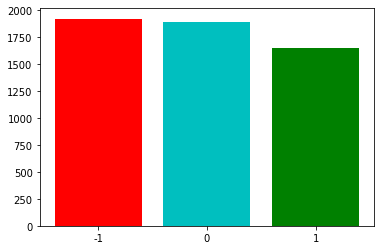

In [26]:
plt.bar(height = obama_train_DA, x = ['-1', '0', '1'], color = ['r', 'c', 'g'])

In [27]:
romney_train_DA = romney_train['Sentiment'].value_counts()
romney_train_DA

-1    2893
 0    1680
 1    1075
Name: Sentiment, dtype: int64

<BarContainer object of 3 artists>

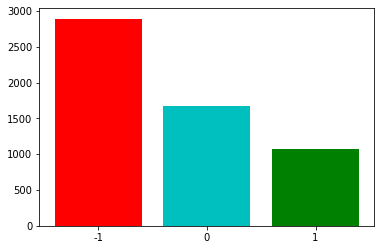

In [28]:
plt.bar(height = romney_train_DA, x = ['-1', '0', '1'], color = ['r', 'c', 'g'])

# Romney data is very imbalanced

## Preprocessing the data

In [29]:
# hm_lines = 5331

# tokenizer = nltk.RegexpTokenizer(r"\w+")
# spell = Speller(lang='en')
# # spell = SpellChecker()

# stop_words = set(stopwords.words('english'))
stop_list = stopwords.words('english')
stop_list.extend(['rt', 'retweet', 'e'])

lemmatizer = WordNetLemmatizer() 

In [30]:
obama_train_pr, romney_train_pr = create_vocab(obama_train, romney_train)

In [31]:
obama_train_pr.head()

,Doc Text,Sentiment
0,kirkpatrick wear baseball cap embroider obama ...,0
2,obama debate cracker as cracker tonight tune t...,1
4,miss point afraid understand big picture dont ...,0
6,raise democrat leave party year ago lifetime n...,-1
7,obama camp can not afford low expectation toni...,0


In [32]:
obama_train_pr['Sentiment'] = obama_train_pr['Sentiment'].apply(lambda x: 'Positive' if x == 1 else ('Negative' if x == -1 else 'Neutral'))

In [33]:
obama_train_pr.head()

,Doc Text,Sentiment
0,kirkpatrick wear baseball cap embroider obama ...,Neutral
2,obama debate cracker as cracker tonight tune t...,Positive
4,miss point afraid understand big picture dont ...,Neutral
6,raise democrat leave party year ago lifetime n...,Negative
7,obama camp can not afford low expectation toni...,Neutral


In [34]:
romney_train_pr.head()

,Doc Text,Sentiment
0,insidious mitt romney bain help philip morris ...,-1
2,mean like romney cheat primary,-1
3,mitt romney still believe black president,-1
4,romney tax plan deserve nd look secret one dif...,-1
5,hope romney debate prepped people last time,1


In [35]:
romney_train_pr['Sentiment'] = romney_train_pr['Sentiment'].apply(lambda x: 'Positive' if x == 1 else ('Negative' if x == -1 else 'Neutral'))

In [36]:
romney_train_pr.head()

,Doc Text,Sentiment
0,insidious mitt romney bain help philip morris ...,Negative
2,mean like romney cheat primary,Negative
3,mitt romney still believe black president,Negative
4,romney tax plan deserve nd look secret one dif...,Negative
5,hope romney debate prepped people last time,Positive


## Splitting the data into training, and validation

In [37]:
obama_train_pr_train, obama_train_pr_val = train_test_split(obama_train_pr, test_size = 0.2)
obama_train_pr_train.head()

,Doc Text,Sentiment
1987,obama force nature debate,Positive
2384,wow group think obama perform well attack idea...,Negative
1293,honey boo boo endorse obama obama president ji...,Positive
1603,exit sir barack time,Negative
413,feel obama still sucker punch leave,Neutral


In [38]:
romney_train_pr_train, romney_train_pr_val = train_test_split(romney_train_pr, test_size = 0.2)
romney_train_pr_train.head()

,Doc Text,Sentiment
706,billy graham prays romney victory,Positive
2537,woman push romney r lead,Neutral
3992,gt gop hop soar romney roll ohio tcot,Positive
4239,eve second debate romney rise cbs news cbc cao...,Positive
3521,romney bury trample female moderator say care ...,Negative


In [ ]:
# training = shuffle(pd.concat([vocab_p_train,vocab_n_train])).reset_index(drop = True)

# validation = pd.concat([vocab_p_val,vocab_n_val]).reset_index(drop = True)

# test = pd.concat([vocab_p_test,vocab_n_test]).reset_index(drop = True)
# # len(validation)

In [39]:
# obama_train_pr_train.to_csv(os.path.join(data_path, 'Obama Training Data.csv'))
# obama_train_pr_val.to_csv(os.path.join(data_path, 'Obama Validation Data.csv'))
# # test.to_csv('Test Data1.csv')

In [40]:
# romney_train_pr_train.to_csv(os.path.join(data_path, 'Romney Training Data.csv'))
# romney_train_pr_val.to_csv(os.path.join(data_path, 'Romney Validation Data.csv'))

In [41]:
obama_train = pd.read_csv(os.path.join(data_path, 'Obama Training Data.csv'), usecols=[1,2])
obama_val = pd.read_csv(os.path.join(data_path, 'Obama Validation Data.csv'), usecols=[1,2])

obama_train.head()

,Doc Text,Sentiment
0,obama force nature debate,Positive
1,wow group think obama perform well attack idea...,Negative
2,honey boo boo endorse obama obama president ji...,Positive
3,exit sir barack time,Negative
4,feel obama still sucker punch leave,Neutral


In [42]:
def one_hot(data):
    temp = np.zeros((len(data),3))
    for i in range(len(temp)):
        if data[i] == 'Negative':
            temp[i][2] = 1 ## Negative sentiment third neuron
        elif data[i] == 'Neutral':
            temp[i][1] = 1 ## Neutral sentiment second neuron  
        else:
            temp[i][0] = 1 ## Positive sentiment first neuron             
    return temp
    
    


In [43]:
romney_train = pd.read_csv(os.path.join(data_path,'Romney Training Data.csv'), usecols=[1,2])
romney_val = pd.read_csv(os.path.join(data_path,'Romney Validation Data.csv'), usecols=[1,2])

romney_val.head()

,Doc Text,Sentiment
0,romney tax plan deserve nd look secret one dif...,Negative
1,romney romney newnikeslogan,Negative
2,need republican friend maybe shed light romney...,Negative
3,mitt people die lack health insurance mitt tal...,Negative
4,romney say borrow money parent college bitch c...,Negative


## Building Glove Dictionary

In [44]:
embeddings = {}
with open(os.path.join(data_path,"glove.6B.300d.txt"), 'r', encoding="utf-8") as file:
    for line in file:
        values = line.split()
        word = values[0]
        vector = asarray(values[1:], dtype='float32')
        embeddings[word] = vector

## Embedding Matrix Function

In [45]:
def emb_matrix(t,embeddings):
    # creating a embedding matrix for the words in training data, which will be used as weight matrix for embedding layer
    vocab_size = len(t.word_index) + 1    
    embedding_matrix = zeros((vocab_size, 300))
    for word, i in t.word_index.items():
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix, vocab_size

## Fine tuning the word embeddings of 300 dimensions using mittens library



## Used the code for finetuning from the following link:
### https://towardsdatascience.com/fine-tune-glove-embeddings-using-mittens-89b5f3fe4c39

In [46]:
def finetune(training): 
    training_tokens = [word_tokenize(i) for i in training['Doc Text']]
    #training_tokens

    oov = [j for i in training_tokens for j in i if j not in embeddings.keys()]
    print(len(oov))

    corp_vocab = list(set(oov))

    cv = CountVectorizer(ngram_range=(1,1), vocabulary=corp_vocab)
    trr =''
    for i in training_tokens:
        for j in i:
            trr+= j
            trr += ' '

    # print(trr)
    # print(z)
    X = cv.fit_transform([trr])
    Xc = (X.T * X)
    Xc.setdiag(0)
    coocc_ar = Xc.toarray()

    mittens_model = Mittens(n=300, max_iter=2000)

    new_embeddings = mittens_model.fit(
      coocc_ar,
      vocab=corp_vocab,
      initial_embedding_dict= embeddings)

    new_embeddings = dict(zip(corp_vocab, new_embeddings))
    return training_tokens, new_embeddings
  


In [47]:
embeddings2= embeddings.copy()

training_tokens, new_embeddings = finetune(obama_train)
embeddings2.update(new_embeddings)

1604


C:\Users\kalya\anaconda3\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Iteration 2000: loss: 0.19232714176177979

In [48]:
oov2 = [j for i in training_tokens for j in i if j not in embeddings2.keys()]
print(len(oov2))

0


## Custom F1 value

In [49]:
def f1_value(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## Building Vanilla RNN, LSTM, and GRU models

In [56]:
def model_vanilla_rnn(embedding_matrix, noh,  vocab_size, max_length, adam_optimizer, activation, Dropout_rate, kernel_regularizer_coef, activity_regularizer_coef):

    model = Sequential()
    e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable = False)
    model.add(e)
    model.add(Bidirectional(SimpleRNN(units = noh, activation = activation, dropout=0.2, kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef))))
    model.add(Dropout(Dropout_rate))
    model.add(Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=[])
#     print(model.summary())
    return model


In [66]:
def model_lstm(embedding_matrix, noh,  vocab_size, max_length, adam_optimizer, activation, Dropout_rate, kernel_regularizer_coef, activity_regularizer_coef):

    model = Sequential()
    e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable = False)
    model.add(e)
    model.add(Bidirectional(LSTM(units = noh, activation = activation, dropout=0.2, kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef))))
    model.add(Dropout(Dropout_rate))
    model.add(Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=[])
#     print(model.summary())
    return model


In [67]:
def model_gru(embedding_matrix, noh,  vocab_size, max_length, adam_optimizer, activation, Dropout_rate, kernel_regularizer_coef, activity_regularizer_coef):

    model = Sequential()
    e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable = False)
    model.add(e)
    model.add(Bidirectional(GRU(units = noh, activation = activation, dropout=0.2, kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef))))
    model.add(Dropout(Dropout_rate))
    model.add(Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=[])
#     print(model.summary())
    return model


In [64]:
# max_length = 40
# epochs = 2
# batch_size = 200
# learning_rate = 0.001

# tokenise_tf = Tokenizer()
# tokenise_tf.fit_on_texts(obama_train['Doc Text'])   
# encoded_train = tokenise_tf.texts_to_sequences(obama_train['Doc Text'])
# training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
# embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings2)

# encoded_validation = tokenise_tf.texts_to_sequences(obama_val['Doc Text'])
# validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding='post', truncating = 'pre')

# adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
# model = model_vanilla_rnn(embedding_matrix, 300, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

# history = model.fit(training_padded, one_hot(obama_train['Sentiment']), epochs=epochs, verbose=1, batch_size=batch_size, shuffle =True)
# y_pred_temp = model.predict(validation_padded)
# y_pred = pred(y_pred_temp)
# f1= f1_score(obama_val['Sentiment'], y_pred, average = 'macro')
# print(f1)




In [ ]:
# u = {}
# u['max_len'] = max_length
# u['batch'] = batch_size
# u['l_rate'] = learning_rate
# u['epochs'] = epochs

# fig, ax = plt.subplots(1,2,figsize = (20,5))

# ax[0].plot(history.history['loss'], label='Training')
# ax[0].plot(history.history['val_loss'], c='r',label='Validation')
# ax[0].legend(loc='upper left')
# ax[0].title.set_text('Loss plot for the combination ' + str(u)) 

# ax[1].plot(history.history['accuracy'], label='Training')
# ax[1].plot(history.history['val_accuracy'], c='r',label='Validation')
# ax[1].legend(loc='upper left')
# ax[1].title.set_text('Accuracy plot for the combination ' + str(u))    

In [ ]:
class Metrics(Callback):
    def __init__(self, validation):   
        super(Metrics, self).__init__()
        self.validation = validation    
            
        print('validation shape', len(self.validation[0]))
        
    def on_train_begin(self, logs={}):        
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
     
    def on_epoch_end(self, epoch, logs={}):
        val_targ = self.validation[1]   
        val_predict = (np.asarray(self.model.predict(self.validation[0]))).round()        
    
        val_f1 = f1_score(val_targ, val_predict)
        val_recall = recall_score(val_targ, val_predict)         
        val_precision = precision_score(val_targ, val_predict)
        
        self.val_f1s.append(round(val_f1, 6))
        self.val_recalls.append(round(val_recall, 6))
        self.val_precisions.append(round(val_precision, 6))
 
        print(f' — val_f1: {val_f1} — val_precision: {val_precision}, — val_recall: {val_recall}')

In [53]:
def pred(x):
    temp = []
    for i in x:
        m = np.argmax(i)
        if m == 0:
            temp.append('Positive')
        elif m == 1:
            temp.append('Neutral')
        else:
            temp.append('Negative')
    return temp

## Building models for obama tweets

## Training the Model

## Using Hyperopt library to tune the Hyperparameters. 

In [73]:
def objective_func(args):
    max_length = args['max_length']
    batch_size = args['batch_size']
    learning_rate = args['learning_rate']
    epochs = args['epochs']

    
    encoded_train = tokenise_tf.texts_to_sequences(obama_train['Doc Text'])
    training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
    embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings2)

    encoded_validation = tokenise_tf.texts_to_sequences(obama_val['Doc Text'])
    validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding='post', truncating = 'pre')

    adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
    model = model_vanilla_rnn(embedding_matrix, 300, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

    history = model.fit(training_padded, one_hot(obama_train['Sentiment']), epochs=epochs, verbose=0, batch_size=batch_size, shuffle =True)
    y_pred_temp = model.predict(validation_padded)
    y_pred = pred(y_pred_temp)
    f1= f1_score(obama_val['Sentiment'], y_pred, average = 'macro')
    # loss, f1 = model.evaluate(validation_padded, one_hot(obama_val['Sentiment']))
#     f1 = history.history['f1_value'][-1]
   
    return -round(f1,2)

space = {'max_length': hp.choice('max_length',range(4,50)),  
        'batch_size': hp.choice('batch_size', [64, 128, 256]),
         'epochs': hp.choice('epochs',range(10,30)), 
         'learning_rate': hp.uniform('learning_rate', 0,0.002)
        }
                                
                                
tokenise_tf = Tokenizer()
tokenise_tf.fit_on_texts(obama_train['Doc Text'])                                
best_vanilla_rnn = fmin(objective_func, space, algo=tpe.suggest, max_evals=20)
print(best_vanilla_rnn)

  5%|▌         | 1/20 [1:31:10<28:52:10, 5470.04s/trial, best loss: -0.56]


KeyboardInterrupt: 

# For vanilla rnn, the best hyper parameters are:
# 'batch_size': 128, 'epochs': 6, 'learning_rate': 0.0003, 'max_length': 68

In [ ]:
# {'batch_size': 0, 'epochs': 7, 'max_length': 59, 'padd': 0, 'trunc': 0}

In [ ]:
def objective_func(args):
    max_length = args['max_length']
    batch_size = args['batch_size']
    learning_rate = args['learning_rate']
    epochs = args['epochs']

    
    encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
    training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
    embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings)

    encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])
    validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding='post', truncating = 'pre')
    
    adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
    model = model_lstm(embedding_matrix, 300, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

    history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=0, batch_size=batch_size, shuffle =True, validation_data = (validation_padded, validation['Sentiment']))
    accuracy = round(history.history['val_accuracy'][-1],2)
    u = {}
    u['max_len'] = max_length
    u['batch'] = batch_size
    u['l_rate'] = round(learning_rate,5)
    u['epochs'] = epochs

    fig, ax = plt.subplots(1,2,figsize = (20,5))

    ax[0].plot(history.history['loss'], label='Training')
    ax[0].plot(history.history['val_loss'], c='r',label='Validation')
    ax[0].legend(loc='upper left')
    ax[0].title.set_text('Loss plot for the combination ' + str(u))


    ax[1].plot(history.history['accuracy'], label='Training')
    ax[1].plot(history.history['val_accuracy'], c='r',label='Validation')
    ax[1].legend(loc='upper left')
    ax[1].title.set_text('Accuracy plot for the combination ' + str(u))  
    plt.show()

    return -round(accuracy,2)

space = {'max_length': hp.choice('max_length',range(4,75)),  
        'batch_size': hp.choice('batch_size', [32, 64, 128]),
         'epochs': hp.choice('epochs',range(5,20)), 
         'learning_rate': hp.uniform('learning_rate', 0,0.002)
        }             
                                
tokenise_tf = Tokenizer()
tokenise_tf.fit_on_texts(training['Doc Text'])                                
best_lstm = fmin(objective_func, space, algo=tpe.suggest, max_evals=10)
print(best_lstm)

# For LSTM rnn, the best hyper parameters are:
# 'batch_size': 128, 'epochs': 10, 'learning_rate': 0.002, 'max_length': 50

In [ ]:
def objective_func(args):
    max_length = args['max_length']
    batch_size = args['batch_size']
    learning_rate = args['learning_rate']
    epochs = args['epochs']
    
    encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
    training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')

    embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings)

    encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])
    validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding='post', truncating = 'pre') 
    
    adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
    model = model_gru(embedding_matrix, 300, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

    history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=0, batch_size=batch_size, shuffle =True, validation_data = (validation_padded, validation['Sentiment']))
    accuracy = history.history['val_accuracy'][-1]
    u = {}
    u['max_len'] = max_length
    u['batch'] = batch_size
    u['l_rate'] = round(learning_rate,5)
    u['epochs'] = epochs

    fig, ax = plt.subplots(1,2,figsize = (20,5))

    ax[0].plot(history.history['loss'], label='Training')
    ax[0].plot(history.history['val_loss'], c='r',label='Validation')
    ax[0].legend(loc='upper left')
    ax[0].title.set_text('Loss plot for the combination ' + str(u))


    ax[1].plot(history.history['accuracy'], label='Training')
    ax[1].plot(history.history['val_accuracy'], c='r',label='Validation')
    ax[1].legend(loc='upper left')
    ax[1].title.set_text('Accuracy plot for the combination ' + str(u))  
    plt.show()

#     encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])

#     validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding=padd, truncating = trunc)
#     loss, accuracy = model.evaluate(validation_padded, validation['Sentiment'], verbose=0)
    return -round((accuracy),2)

space = {'max_length': hp.choice('max_length',range(4,75)),  
        'batch_size': hp.choice('batch_size', [32, 64, 128]),
         'epochs': hp.choice('epochs',range(5,20)), 
         'learning_rate': hp.uniform('learning_rate', 0,0.002)
        }
                                
                                
tokenise_tf = Tokenizer()
tokenise_tf.fit_on_texts(training['Doc Text'])                                
best_gru = fmin(objective_func, space, algo=tpe.suggest, max_evals=10)
print(best_gru)

# For GRU rnn, the best hyper parameters are:
# 'batch_size': 64, 'epochs': 7, 'learning_rate': 0.0006, 'max_length': 11

In [ ]:
# max_length = 40
# epochs = 15
# batch_size = 64
# learning_rate = 0.001

# encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
# training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
# embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings)

# encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])
# validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding='post', truncating = 'pre')

# adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
# model = model_vanilla_rnn(embedding_matrix, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

# history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=2, batch_size=batch_size, shuffle =True, validation_data = (validation_padded, validation['Sentiment']))
# accuracy = history.history['val_accuracy'][-1]



# Experimenting with the Network Architecture

## Using the Final hidden state as the output

## max_length = 40
## epochs = 15
## batch_size = 64
## learning_rate = 0.001

In [ ]:

def par_selec(model_r, max_length, nnh):
  # max_length = 40
  epochs = 15
  batch_size = 64
  learning_rate = 0.001

  tokenise_tf = Tokenizer()
  tokenise_tf.fit_on_texts(training['Doc Text']) 

  encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
  training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')

  embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings)

  encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])
  validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding='post', truncating = 'pre')


  adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
  model = model_r(embedding_matrix, nnh, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

  history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=0, batch_size=batch_size, shuffle =True, validation_data = (validation_padded, validation['Sentiment']))
  accuracy = history.history['val_accuracy'][-1]

  u = {}
  u['max_len'] = max_length
  u['batch'] = batch_size
  u['l_rate'] = learning_rate
  u['epochs'] = epochs

  fig, ax = plt.subplots(1,2,figsize = (20,5))

  ax[0].plot(history.history['loss'], label='Training')
  ax[0].plot(history.history['val_loss'], c='r',label='Validation')
  ax[0].legend(loc='upper left')
  ax[0].title.set_text('Loss plot for the combination ' + str(u))


  ax[1].plot(history.history['accuracy'], label='Training')
  ax[1].plot(history.history['val_accuracy'], c='r',label='Validation')
  ax[1].legend(loc='upper left')
  ax[1].title.set_text('Accuracy plot for the combination ' + str(u))  
  plt.show()

  print('Accuracy for ' + str(nnh) + ' hidden units ' + str(max_length) + ' sequence length: ' + str(accuracy))


## Changing the no of hidden units
## Keeping max_length = 40
## epochs = 15
## batch_size = 64
## learning_rate = 0.001


In [ ]:
par_selec(model_vanilla_rnn, 40, 300)

In [ ]:
par_selec(model_lstm, 40, 300)

In [ ]:
par_selec(model_gru, 40, 300)

## Doubling the no of hidden units

In [ ]:
par_selec(model_vanilla_rnn, 40, 600)

### For Vanilla RNN,  With double the no of hidden units, the accuracy reduced from 60 to 56 percent.

In [ ]:
par_selec(model_lstm, 40, 600)

### For LSTM, With double the no of hidden units, the accuracy slightly increased from 72 to 73 percent.

In [ ]:
par_selec(model_gru, 40, 600)

### For GRU, With double the no of hidden units, the accuracy didn't change from 50

# Halving the no of hidden units

In [ ]:
par_selec(model_vanilla_rnn, 40, 150)

### With halve the no of hidden units, the accuracy increased from 60 to 73.

In [ ]:
par_selec(model_lstm, 40, 150)

### For LSTM, With halve the no of hidden units, the accuracy increased from 72 to 74 percent.

In [ ]:
par_selec(model_gru, 40, 150)

### For GRU, With halve the no of hidden units, the accuracy remain unchanged.

# Changing the max_length 
# Keeping no of hidden units = 300
# epochs = 15
# batch_size = 64
# learning_rate = 0.001


## Doubling the sequence length from 40 to 80

In [ ]:
par_selec(model_vanilla_rnn, 80, 300)

### For vanilla rnn, With double the sequence length, there was a decrease in accuracy from 60 to 53



In [ ]:
par_selec(model_lstm, 80, 300)

### For LSTM, With double the sequence length, there was a decrease in accuracy from 72 to 50



In [ ]:
par_selec(model_gru, 80, 300)

### For GRU, With double the sequence length, there was no change in accuracy from 50



# When we increase the sequence length we might include noisy (unimportant) words that would change the sentiment of the sentence


## Halving the sequence length from 40 to 20

In [ ]:
par_selec(model_vanilla_rnn, 20, 300)

### For vanilla RNN, With half the sequence length, there was an increase in accuracy from 60 to 73


In [ ]:
par_selec(model_lstm, 20, 300)

### For LSTM, With half the sequence length, the accuracy increased from 72 to 74 percent.


In [ ]:
par_selec(model_gru, 20, 300)

### For GRU, With half the sequence length, the accuracy increased from 50 to 74 percent.



## It makes sense as when we decrease the sequence length we might concentrate more on the important words that change the sentiment of the sentence

###

## Fine tuning the word embeddings of 300 dimensions using mittens library

In [ ]:
def finetune(training): 
  training_tokens = [word_tokenize(i) for i in training['Doc Text']]
  #training_tokens

  oov = [j for i in training_tokens for j in i if j not in embeddings.keys()]
  print(len(oov))

  corp_vocab = list(set(oov))

  cv = CountVectorizer(ngram_range=(1,1), vocabulary=corp_vocab)
  trr =''
  for i in training_tokens:
    for j in i:
      trr+= j
      trr += ' '

  # print(trr)
  # print(z)
  X = cv.fit_transform([trr])
  Xc = (X.T * X)
  Xc.setdiag(0)
  coocc_ar = Xc.toarray()

  mittens_model = Mittens(n=300, max_iter=1000)

  new_embeddings = mittens_model.fit(
      coocc_ar,
      vocab=corp_vocab,
      initial_embedding_dict= embeddings)

  new_embeddings = dict(zip(corp_vocab, new_embeddings))
  return training_tokens, new_embeddings
  


In [ ]:
embeddings2= embeddings.copy()

training_tokens, new_embeddings = finetune(training)
embeddings2.update(new_embeddings)

In [ ]:
oov2 = [j for i in training_tokens for j in i if j not in embeddings2.keys()]
print(len(oov2))

### Using new embeddings for the vanilla rnn em

In [ ]:
def objective_func(args):
    max_length = args['max_length']
    batch_size = args['batch_size']
    learning_rate = args['learning_rate']
    epochs = args['epochs']

    
    encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
    training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')

    embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings2)

    encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])
    validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding='post', truncating = 'pre') 
    
    adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
    model = model_vanilla_rnn(embedding_matrix, 300, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

    history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=0, batch_size=batch_size, shuffle =True, validation_data = (validation_padded, validation['Sentiment']))
    accuracy = history.history['val_accuracy'][-1]
    u = {}
    u['max_len'] = max_length
    u['batch'] = batch_size
    u['l_rate'] = round(learning_rate,5)
    u['epochs'] = epochs

    fig, ax = plt.subplots(1,2,figsize = (20,5))

    ax[0].plot(history.history['loss'], label='Training')
    ax[0].plot(history.history['val_loss'], c='r',label='Validation')
    ax[0].legend(loc='upper left')
    ax[0].title.set_text('Loss plot for the combination ' + str(u))


    ax[1].plot(history.history['accuracy'], label='Training')
    ax[1].plot(history.history['val_accuracy'], c='r',label='Validation')
    ax[1].legend(loc='upper left')
    ax[1].title.set_text('Accuracy plot for the combination ' + str(u))  
    plt.show()

#     encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])

#     validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding=padd, truncating = trunc)
#     loss, accuracy = model.evaluate(validation_padded, validation['Sentiment'], verbose=0)
    return -round(accuracy,2)

space = {'max_length': hp.choice('max_length',range(4,75)),  
        'batch_size': hp.choice('batch_size', [32, 64, 128]),
         'epochs': hp.choice('epochs',range(5,20)), 
         'learning_rate': hp.uniform('learning_rate', 0,0.002)
        }
                                
                                
tokenise_tf = Tokenizer()
tokenise_tf.fit_on_texts(training['Doc Text'])                                
best_vanilla_rnn2 = fmin(objective_func, space, algo=tpe.suggest, max_evals=10)
print(best_vanilla_rnn2)

In [ ]:
def objective_func(args):
    max_length = args['max_length']
    batch_size = args['batch_size']
    learning_rate = args['learning_rate']
    epochs = args['epochs']

    
    encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
    training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')

    embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings2)

    encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])
    validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding='post', truncating = 'pre') 
    
    adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
    model = model_lstm(embedding_matrix, 300, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

    history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=0, batch_size=batch_size, shuffle =True, validation_data = (validation_padded, validation['Sentiment']))
    accuracy = history.history['val_accuracy'][-1]
    u = {}
    u['max_len'] = max_length
    u['batch'] = batch_size
    u['l_rate'] = round(learning_rate,5)
    u['epochs'] = epochs

    fig, ax = plt.subplots(1,2,figsize = (20,5))

    ax[0].plot(history.history['loss'], label='Training')
    ax[0].plot(history.history['val_loss'], c='r',label='Validation')
    ax[0].legend(loc='upper left')
    ax[0].title.set_text('Loss plot for the combination ' + str(u))


    ax[1].plot(history.history['accuracy'], label='Training')
    ax[1].plot(history.history['val_accuracy'], c='r',label='Validation')
    ax[1].legend(loc='upper left')
    ax[1].title.set_text('Accuracy plot for the combination ' + str(u))  
    plt.show()

#     encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])

#     validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding=padd, truncating = trunc)
#     loss, accuracy = model.evaluate(validation_padded, validation['Sentiment'], verbose=0)
    return -round(accuracy,2)

space = {'max_length': hp.choice('max_length',range(4,75)),  
        'batch_size': hp.choice('batch_size', [32, 64, 128]),
         'epochs': hp.choice('epochs',range(5,20)), 
         'learning_rate': hp.uniform('learning_rate', 0,0.002)
        }
                                
                                
tokenise_tf = Tokenizer()
tokenise_tf.fit_on_texts(training['Doc Text'])                                
best_lstm2 = fmin(objective_func, space, algo=tpe.suggest, max_evals=10)
print(best_lstm2)

In [ ]:
def objective_func(args):
    max_length = args['max_length']
    batch_size = args['batch_size']
    learning_rate = args['learning_rate']
    epochs = args['epochs']

    
    encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
    training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')

    embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings2)

    encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])
    validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding='post', truncating = 'pre') 
    
    adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
    model = model_gru(embedding_matrix, 300, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

    history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=0, batch_size=batch_size, shuffle =True, validation_data = (validation_padded, validation['Sentiment']))
    accuracy = history.history['val_accuracy'][-1]
    u = {}
    u['max_len'] = max_length
    u['batch'] = batch_size
    u['l_rate'] = round(learning_rate,5)
    u['epochs'] = epochs

    fig, ax = plt.subplots(1,2,figsize = (20,5))

    ax[0].plot(history.history['loss'], label='Training')
    ax[0].plot(history.history['val_loss'], c='r',label='Validation')
    ax[0].legend(loc='upper left')
    ax[0].title.set_text('Loss plot for the combination ' + str(u))


    ax[1].plot(history.history['accuracy'], label='Training')
    ax[1].plot(history.history['val_accuracy'], c='r',label='Validation')
    ax[1].legend(loc='upper left')
    ax[1].title.set_text('Accuracy plot for the combination ' + str(u))  
    plt.show()

#     encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])

#     validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding=padd, truncating = trunc)
#     loss, accuracy = model.evaluate(validation_padded, validation['Sentiment'], verbose=0)
    return -round(accuracy,2)

space = {'max_length': hp.choice('max_length',range(4,75)),  
        'batch_size': hp.choice('batch_size', [32, 64, 128]),
         'epochs': hp.choice('epochs',range(5,20)), 
         'learning_rate': hp.uniform('learning_rate', 0,0.002)
        }
                                
                                
tokenise_tf = Tokenizer()
tokenise_tf.fit_on_texts(training['Doc Text'])                                
best_gru2 = fmin(objective_func, space, algo=tpe.suggest, max_evals=10)
print(best_gru2)

# For all the three RNNs,I got best accuracy when they were trained on the pre-trained and fine-tuned word embeddings.



In [ ]:
batch_size_temp = [32,64,128]

# I got best validation accuracy of 73 with Vanilla RNN model trained on the pre trained and fine tuned word embeddings with hyperparameters: 

## 'batch_size': 128, 'epochs': 11, 'learning_rate': 0.0016, 'max_length': 8

In [ ]:
# best_vanilla_rnn2['batch_size'] = batch_size_temp[best_vanilla_rnn2['batch_size']]
# best_v_r_df = pd.DataFrame(data = best_vanilla_rnn2.items(),index=best_vanilla_rnn2.keys())
# best_v_r_df.to_csv('best_v_r.csv')

# I got best validation accuracy of 75 with LSTM model trained on the pre trained and fine tuned word embeddings with hyperparameters: 

## 'batch_size': 64, 'epochs': 12, 'learning_rate': 0.0018206437643498807, 'max_length': 15

In [ ]:
# best_l_r['batch_size'] = batch_size_temp[best_l_r['batch_size']]
# best_l_r_df = pd.DataFrame(best_l_r.items(),index=best_l_r.keys())
# best_l_r_df.to_csv('best_l_r.csv')

# I got best validation accuracy of 74 with GRU model trained on the pre trained and fine tuned word embeddings with hyperparameters: 

## 'batch_size': 64, 'epochs': 11, 'learning_rate': 0.001, 'max_length': 19

In [ ]:
# best_g_r = {'batch_size': 64, 'epochs': 11, 'learning_rate': 0.001, 'max_length': 19}
# best_g_r_df = pd.DataFrame(best_g_r.items(),index=best_g_r.keys())
# best_g_r_df.to_csv('best_g_r.csv')

## Out of the three above, LSTM performed best on the validation data

# ###

# Evaluating on the test data

In [ ]:
test = pd.read_csv('Test Data1.csv').iloc[:,1:]

test.head()

In [ ]:
def test_evaluation(test, model, max_length, batch_size, epochs, learning_rate):
  tokenise_tf = Tokenizer()
  tokenise_tf.fit_on_texts(training['Doc Text']) 
  
  encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
  training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')

  embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings2)

  encoded_test = tokenise_tf.texts_to_sequences(test['Doc Text'])
  test_padded = pad_sequences(encoded_test, maxlen=max_length, padding='post', truncating = 'pre') 
  
  adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
  model2 = model(embedding_matrix, 300, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

  history = model2.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=0, batch_size=batch_size, shuffle =True)
  temp = lambda x: 1 if x>= 0.5 else 0 
  y_pred = [temp(i) for i in model2.predict(test_padded)]
  # print(y_pred) 
  y_test = test['Sentiment']
  # print(y_test)
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  return accuracy, precision, recall, f1

In [ ]:
# Testing Vanilla RNN

In [ ]:
best_v_r_df2 = pd.read_csv('best_v_r.csv')
Vanilla_acc, Vanilla_prec, Vanilla_rec, Vanilla_f1= test_evaluation(test, model_vanilla_rnn, best_v_r_df2['max_length'][0], best_v_r_df2['batch_size'][0], best_v_r_df2['epochs'][0], best_v_r_df2['learning_rate'][0])
print('Accuracy of Vanilla RNN on the test data: ' + str(Vanilla_acc))
print('Accuracy of Vanilla RNN on the test data: ' + str(Vanilla_prec))
print('Accuracy of Vanilla RNN on the test data: ' + str(Vanilla_rec))
print('Accuracy of Vanilla RNN on the test data: ' + str(Vanilla_f1))

In [ ]:
# Testing LSTM 

In [ ]:
best_lstm_df2 = pd.read_csv('best_l_r.csv')
lstm_acc, lstm_prec, lstm_rec, lstm_f1= test_evaluation(test, model_lstm, best_lstm_df2['max_length'][0], best_lstm_df2['batch_size'][0], best_lstm_df2['epochs'][0], best_lstm_df2['learning_rate'][0])
print('Accuracy of LSTM RNN on the test data: ' + str(lstm_acc))
print('Accuracy of LSTM RNN on the test data: ' + str(lstm_prec))
print('Accuracy of LSTM RNN on the test data: ' + str(lstm_rec))
print('Accuracy of LSTM RNN on the test data: ' + str(lstm_f1))

In [ ]:
# Testing GRU

In [ ]:
best_gru_df2 = pd.read_csv('best_g_r.csv')
gru_acc, gru_prec,gru_rec,gru_f1= test_evaluation(test, model_gru, best_gru_df2['max_length'][0], best_gru_df2['batch_size'][0], best_gru_df2['epochs'][0], best_gru_df2['learning_rate'][0])
print('Accuracy of GRU RNN on the test data: ' + str(gru_acc))
print('Accuracy of GRU RNN on the test data: ' + str(gru_prec))
print('Accuracy of GRU RNN on the test data: ' + str(gru_rec))
print('Accuracy of GRU RNN on the test data: ' + str(gru_f1))

## I got best test accuracy of 75 percent with the GRU RNN 

# Observed differences between the performances of the three rnns:
## Got best validation accuracy with LSTM but got best test accuracy with GRU
## Vanilla RNN is fastest and LSTM is slowest in terms of training because LSTM has more parameters and heavier computation
## Vanilla RNN gave comparitively lowest accuracies after hyper parameter tuning maybe because of vanishing gradient problem.


# ##########

# Ignore the code from now on. I just wanted to save the code for element-wise max.
# With the element_wise max of all the hidden states as the output, I got less accuracy of 50. Whatever the parameters, the accuracy didn't cross 0.5

## Taking elementwise max of the hidden states

In [ ]:
def model_vanilla_rnn_em(embedding_matrix, noh, vocab_size, max_length, adam_optimizer, activation, Dropout_rate, kernel_regularizer_coef, activity_regularizer_coef):

    model = Sequential()
    e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable = False)
    model.add(e)
    model.add(SimpleRNN(units = noh, activation = activation, dropout=0.2, return_sequences=True, kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.add(MaxPool1D(max_length, strides = None))
    # model.add(Dropout(Dropout_rate))

#     model.add(Dense(1, activation='softmax'))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#     print(model.summary())
    
#     print(z)
    return model


In [ ]:
def model_lstm_em(embedding_matrix, noh, vocab_size, max_length, adam_optimizer, activation, Dropout_rate, kernel_regularizer_coef, activity_regularizer_coef):

    model = Sequential()
    e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable = False)
    model.add(e)
    model.add(LSTM(units = noh, activation = activation, dropout=0.2, return_sequences=True, kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.add(MaxPool1D(max_length, strides = None))
    # model.add(Dropout(Dropout_rate))

#     model.add(Dense(1, activation='softmax'))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#     print(model.summary())
    
#     print(z)
    return model


In [ ]:
def model_gru_em(embedding_matrix, noh, vocab_size, max_length, adam_optimizer, activation, Dropout_rate, kernel_regularizer_coef, activity_regularizer_coef):

    model = Sequential()
    e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable = False)
    model.add(e)
    model.add(GRU(units = noh, activation = activation, dropout=0.2, return_sequences=True, kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.add(MaxPool1D(max_length, strides = None))
#     model.add(Dropout(Dropout_rate))

#     model.add(Dense(1, activation='softmax'))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#     print(model.summary())
    
#     print(z)
    return model


## Changing the no of hidden units
## Keeping max_length = 40
## epochs = 15
## batch_size = 64
## learning_rate = 0.001


In [ ]:
par_selec(model_vanilla_rnn_em, 40, 300)

In [ ]:
par_selec(model_lstm_em, 40, 300)

In [ ]:
par_selec(model_gru_em, 40, 300)

## Doubling the no of hidden units

In [ ]:
par_selec(model_vanilla_rnn_em, 40, 300)

### For Vanilla RNN,  With double the no of hidden units, the accuracy reduced from 74 to 73 percent.

In [ ]:
par_selec(model_lstm_em, 40, 600)

### For LSTM, With double the no of hidden units, the accuracy reduced from 74 to 73 percent.

In [ ]:
par_selec(model_gru_em, 40, 600)

### For GRU, With double the no of hidden units, the accuracy reduced from 74 to 73 percent.

# Halving the no of hidden units

In [ ]:
par_selec(model_vanilla_rnn_em, 40, 150)

### With halve the no of hidden units, the accuracy increased slightly from 73.8 to 74.4.

In [ ]:
par_selec(model_lstm_em, 40, 150)

### For LSTM, With halve the no of hidden units, the accuracy reduced from 74 to 73 percent.

In [ ]:
par_selec(model_gru_em, 40, 150)

### For GRU, With halve the no of hidden units, the accuracy reduced from 74 to 73 percent.

# Changing the max_length 
# Keeping no of hidden units = 300
# epochs = 15
# batch_size = 64
# learning_rate = 0.001


## Doubling the sequence length from 40 to 80

In [ ]:
par_selec(model_vanilla_rnn_em, 80, 300)

### For vanilla rnn, With double the sequence length, there was an insignificant increase in accuracy from 73.83 to 73.87



In [ ]:
par_selec(model_lstm_em, 80, 300)

### For LSTM, With double the sequence length, there was an insignificant increase in accuracy from 73.83 to 73.87



In [ ]:
par_selec(model_gru_em, 80, 300)

### For GRU, With double the sequence length, there was an insignificant increase in accuracy from 73.83 to 73.87



### When we increase the sequence length we might include important words that would change the sentiment of the sentence

## Halving the sequence length from 40 to 20

In [ ]:
par_selec(model_vanilla_rnn_em, 20, 300)

In [ ]:
# max_length = 20
# epochs = 15
# batch_size = 64
# learning_rate = 0.001

# encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
# training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
# embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings)

# encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])
# validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding='post', truncating = 'pre')

# adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
# model = model_vanilla_rnn(embedding_matrix, 300, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

# history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=2, batch_size=batch_size, shuffle =True, validation_data = (validation_padded, validation['Sentiment']))
# accuracy = history.history['val_accuracy'][-1]



### For vanilla RNN, With half the sequence length, there was a slight decrease in accuracy from 73.8 to 73.2


In [ ]:
par_selec(model_lstm_em, 20, 300)

### For LSTM, With half the sequence length, there was a slight decrease in accuracy from 73.8 to 73.2


In [ ]:
par_selec(model_gru_em, 20, 300)

### For GRU, With half the sequence length, there was a slight decrease in accuracy from 73.8 to 73.2



### It makes sense as when we decrease the sequence length we might lose important words that change the sentiment of the sentence

###

## Fine tuning the word embeddings using mittens library

In [ ]:
def finetune(training): 
  training_tokens = [word_tokenize(i) for i in training['Doc Text']]
  #training_tokens

  oov = [j for i in training_tokens for j in i if j not in embeddings.keys()]
  print(len(oov))

  corp_vocab = list(set(oov))

  cv = CountVectorizer(ngram_range=(1,1), vocabulary=corp_vocab)
  trr =''
  for i in training_tokens:
    for j in i:
      trr+= j
      trr += ' '

  # print(trr)
  # print(z)
  X = cv.fit_transform([trr])
  Xc = (X.T * X)
  Xc.setdiag(0)
  coocc_ar = Xc.toarray()

  mittens_model = Mittens(n=300, max_iter=1000)

  new_embeddings = mittens_model.fit(
      coocc_ar,
      vocab=corp_vocab,
      initial_embedding_dict= embeddings)

  new_embeddings = dict(zip(corp_vocab, new_embeddings))
  return training_tokens, new_embeddings
  


In [ ]:
embeddings2= embeddings.copy()

training_tokens, new_embeddings = finetune(training)
embeddings2.update(new_embeddings)

In [ ]:
oov2 = [j for i in training_tokens for j in i if j not in embeddings2.keys()]
print(len(oov2))

### Using new embeddings for the vanilla rnn em

In [ ]:
def objective_func(args):
    max_length = args['max_length']
    batch_size = args['batch_size']
    learning_rate = args['learning_rate']
    epochs = args['epochs']

    
    encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
    training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')

    embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings2)

    encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])
    validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding='post', truncating = 'pre') 
    
    adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
    model = model_vanilla_rnn_em(embedding_matrix, 300, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

    history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=0, batch_size=batch_size, shuffle =True, validation_data = (validation_padded, validation['Sentiment']))
    accuracy = history.history['val_accuracy'][-1]
    u = {}
    u['max_len'] = max_length
    u['batch'] = batch_size
    u['l_rate'] = round(learning_rate,5)
    u['epochs'] = epochs

    fig, ax = plt.subplots(1,2,figsize = (20,5))

    ax[0].plot(history.history['loss'], label='Training')
    ax[0].plot(history.history['val_loss'], c='r',label='Validation')
    ax[0].legend(loc='upper left')
    ax[0].title.set_text('Loss plot for the combination ' + str(u))


    ax[1].plot(history.history['accuracy'], label='Training')
    ax[1].plot(history.history['val_accuracy'], c='r',label='Validation')
    ax[1].legend(loc='upper left')
    ax[1].title.set_text('Accuracy plot for the combination ' + str(u))  
    plt.show()

#     encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])

#     validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding=padd, truncating = trunc)
#     loss, accuracy = model.evaluate(validation_padded, validation['Sentiment'], verbose=0)
    return -round(accuracy,2)

space = {'max_length': hp.choice('max_length',range(4,75)),  
        'batch_size': hp.choice('batch_size', [32, 64, 128]),
         'epochs': hp.choice('epochs',range(5,20)), 
         'learning_rate': hp.uniform('learning_rate', 0,0.002)
        }
                                
                                
tokenise_tf = Tokenizer()
tokenise_tf.fit_on_texts(training['Doc Text'])                                
best_vanilla_rnn_em2 = fmin(objective_func, space, algo=tpe.suggest, max_evals=10)
print(best_vanilla_rnn_em2)

In [ ]:
def objective_func(args):
    max_length = args['max_length']
    batch_size = args['batch_size']
    learning_rate = args['learning_rate']
    epochs = args['epochs']

    
    encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
    training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
    embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings2)

    encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])
    validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding='post', truncating = 'pre')
    
    adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
    model = model_vanilla_rnn(embedding_matrix, 300, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

    history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=0, batch_size=batch_size, shuffle =True, validation_data = (validation_padded, validation['Sentiment']))
    accuracy = history.history['val_accuracy'][-1]
    u = {}
    u['max_len'] = max_length
    u['batch'] = batch_size
    u['l_rate'] = round(learning_rate,5)
    u['epochs'] = epochs

    fig, ax = plt.subplots(1,2,figsize = (20,5))

    ax[0].plot(history.history['loss'], label='Training')
    ax[0].plot(history.history['val_loss'], c='r',label='Validation')
    ax[0].legend(loc='upper left')
    ax[0].title.set_text('Loss plot for the combination ' + str(u))


    ax[1].plot(history.history['accuracy'], label='Training')
    ax[1].plot(history.history['val_accuracy'], c='r',label='Validation')
    ax[1].legend(loc='upper left')
    ax[1].title.set_text('Accuracy plot for the combination ' + str(u))  
    plt.show()

#     encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])

#     validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding=padd, truncating = trunc)
#     loss, accuracy = model.evaluate(validation_padded, validation['Sentiment'], verbose=0)
    return -round((accuracy),2)

space = {'max_length': hp.choice('max_length',range(4,75)),  
        'batch_size': hp.choice('batch_size', [32, 64, 128]),
         'epochs': hp.choice('epochs',range(5,20)), 
         'learning_rate': hp.uniform('learning_rate', 0,0.002)
        }
                                
                                
tokenise_tf = Tokenizer()
tokenise_tf.fit_on_texts(training['Doc Text'])                                
best_vanilla_rnn_em = fmin(objective_func, space, algo=tpe.suggest, max_evals=10)
print(best_vanilla_rnn_em)

In [ ]:
def objective_func(args):
    max_length = args['max_length']
    batch_size = args['batch_size']
    learning_rate = args['learning_rate']
    epochs = args['epochs']

    
    encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
    training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
    embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings)
    adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
    model = model_lstm_em(embedding_matrix, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

    history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=0, batch_size=batch_size, shuffle =True, validation_split = 0.25)
    accuracy = history.history['val_accuracy'][-1]
    u = {}
    u['max_len'] = max_length
    u['batch'] = batch_size
    u['l_rate'] = learning_rate
    u['epochs'] = epochs

    fig, ax = plt.subplots(1,2,figsize = (20,5))

    ax[0].plot(history.history['loss'], label='Training')
    ax[0].plot(history.history['val_loss'], c='r',label='Validation')
    ax[0].legend(loc='upper left')
    ax[0].title.set_text('Loss plot for the combination ' + str(u))


    ax[1].plot(history.history['accuracy'], label='Training')
    ax[1].plot(history.history['val_accuracy'], c='r',label='Validation')
    ax[1].legend(loc='upper left')
    ax[1].title.set_text('Accuracy plot for the combination ' + str(u))  
    plt.show()

#     encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])

#     validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding=padd, truncating = trunc)
#     loss, accuracy = model.evaluate(validation_padded, validation['Sentiment'], verbose=0)
    return -round((accuracy),2)

space = {'max_length': hp.choice('max_length',range(4,50)),  
        'batch_size': hp.choice('batch_size', [32, 64, 128]),
         'epochs': hp.choice('epochs',range(5,20)), 
         'learning_rate': hp.uniform('learning_rate', 0,0.002)
        }
                                
                                
tokenise_tf = Tokenizer()
tokenise_tf.fit_on_texts(training['Doc Text'])                                
best_lstm_em = fmin(objective_func, space, algo=tpe.suggest, max_evals=10)
print(best_lstm_em)

In [ ]:
def objective_func(args):
    max_length = args['max_length']
    batch_size = args['batch_size']
    learning_rate = args['learning_rate']
    epochs = args['epochs']

    
    encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
    training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
    embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings)
    adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
    model = model_gru_em(embedding_matrix, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

    history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=0, batch_size=batch_size, shuffle =True, validation_split = 0.25)
    accuracy = history.history['val_accuracy'][-1]
    u = {}
    u['max_len'] = max_length
    u['batch'] = batch_size
    u['l_rate'] = learning_rate
    u['epochs'] = epochs

    fig, ax = plt.subplots(1,2,figsize = (20,5))

    ax[0].plot(history.history['loss'], label='Training')
    ax[0].plot(history.history['val_loss'], c='r',label='Validation')
    ax[0].legend(loc='upper left')
    ax[0].title.set_text('Loss plot for the combination ' + str(u))


    ax[1].plot(history.history['accuracy'], label='Training')
    ax[1].plot(history.history['val_accuracy'], c='r',label='Validation')
    ax[1].legend(loc='upper left')
    ax[1].title.set_text('Accuracy plot for the combination ' + str(u))  
    plt.show()

#     encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])

#     validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding=padd, truncating = trunc)
#     loss, accuracy = model.evaluate(validation_padded, validation['Sentiment'], verbose=0)
    return -round((accuracy),2)

space = {'max_length': hp.choice('max_length',range(4,50)),  
        'batch_size': hp.choice('batch_size', [32, 64, 128]),
         'epochs': hp.choice('epochs',range(5,20)), 
         'learning_rate': hp.uniform('learning_rate', 0,0.002)
        }
                                
                                
tokenise_tf = Tokenizer()
tokenise_tf.fit_on_texts(training['Doc Text'])                                
best_gru_em = fmin(objective_func, space, algo=tpe.suggest, max_evals=10)
print(best_gru_em)

In [ ]:
# training.to_csv('Training Data.csv')
# test.to_csv('Test Data.csv')

In [ ]:
# def generate_embedding_matrix(word_embeddings):
#     vocabulary_size = len(tokenizer.word_index)+1
#     embedding_matrix = np.zeros((vocabulary_size, 300))
#     for word, index in tokenizer.word_index.items():
#         embedding_vector = word_embeddings.get(word)
#         if embedding_vector is not None:
#             embedding_matrix[index] = embedding_vector
#     return embedding_matrix,vocabulary_size

In [ ]:
# input_len = 50
# tokenizer = Tokenizer(oov_token='<OOV>')
# tokenizer.fit_on_texts(training['Doc Text'])
# X_train_processed = tokenizer.texts_to_sequences(training['Doc Text'])
# X_train_processed = pad_sequences(X_train_processed, padding='post', maxlen=input_len,truncating='pre')
# embedding_matrix,vocabulary_size = generate_embedding_matrix(embeddings)
# tf.keras.backend.clear_session()
# model = Sequential()
# embedding_layer = Embedding(vocabulary_size, 300, weights=[embedding_matrix], input_length=input_len,trainable = False,mask_zero=True)
# model.add(embedding_layer)
# model.add(SimpleRNN(300,kernel_regularizer = tf.keras.regularizers.L1(0.01)))

# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))
# # adam_optimizer = optimizers.adam(learning_rate=learning_rate)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# print(model.summary())
# model.fit(X_train_processed, training['Sentiment'], batch_size=128, epochs=30, verbose=1)

In [ ]:
def model_vanilla_rnn_bd(embedding_matrix, vocab_size, max_length, adam_optimizer, activation, Dropout_rate, kernel_regularizer_coef, activity_regularizer_coef):

    model = Sequential()
    e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable = False)
    model.add(e)
    model.add(Bidirectional(SimpleRNN(units = 300, activation = activation, kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef))))
    model.add(Dropout(Dropout_rate))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#     print(model.summary())
    return model


In [ ]:
max_length = 40
epochs = 15
learning_rate = 0.001
batch_size = 64
encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings)
adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
model = model_vanilla_rnn_bd(embedding_matrix, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=1, batch_size=batch_size, shuffle =True, validation_split = 0.25)
accuracy = history.history['val_accuracy'][-1]

In [ ]:
def model_lstm_bd(embedding_matrix, vocab_size, max_length, adam_optimizer, activation, Dropout_rate, kernel_regularizer_coef, activity_regularizer_coef):

    model = Sequential()
    e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable = False)
    model.add(e)
    model.add(Bidirectional(LSTM(units = 300, activation = activation, kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef))))
    model.add(Dropout(Dropout_rate))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#     print(model.summary())
    return model


In [ ]:
max_length = 40
epochs = 20
learning_rate = 0.001
batch_size = 128
encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings)
adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
model = model_lstm_bd(embedding_matrix, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=1, batch_size=batch_size, shuffle =True, validation_split = 0.25)
accuracy = history.history['val_accuracy'][-1]

In [ ]:
def objective_func(args):
    max_length = args['max_length']
#     af_in_simpleRNN = args['af_in_simpleRNN']
    batch_size = args['batch_size']
    learning_rate = args['learning_rate']
#     padd = args['padd']
#     trunc = args['trunc']
    epochs = args['epochs']
#     kernel_regularizer_coef = args['kernel_regularizer_coef']
#     activity_regularizer_coef = args['activity_regularizer_coef']
#     Dropout_rate = args['Dropout_rate']
    
    encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
    training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
    embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings)
    adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
    model = model_vanilla_rnn_bd(embedding_matrix, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)
    
    history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=0, batch_size=batch_size, shuffle =True, validation_split = 0.25)
    accuracy = history.history['val_accuracy'][-1]
    
    # summarize history for accuracy
    plt.figure(figsize=(10,5))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()    
    
#     encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])

#     validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding=padd, truncating = trunc)
#     loss, accuracy = model.evaluate(validation_padded, validation['Sentiment'], verbose=0)
    return -round((accuracy),2)

space = {'max_length': hp.choice('max_length',range(4,100)), 
#          'af_in_simpleRNN': hp.choice('af_in_simpleRNN', ['tanh', 'sigmoid']), 
        'batch_size': hp.choice('batch_size', [64, 128, 256]),
#          'padd': hp.choice('padd', ['pre', 'post']),
#          'trunc': hp.choice('trunc', ['pre', 'post']),
         'epochs': hp.choice('epochs',range(5,20)), 
         'learning_rate': hp.uniform('learning_rate', 0,1)
#          'Dropout_rate': hp.uniform('Dropout_rate', 0, 1),
#          'kernel_regularizer_coef': hp.uniform('kernel_regularizer_coef', 0, 10),
#          'activity_regularizer_coef': hp.uniform('activity_regularizer_coef', 0, 10)
        }
                                
                                
tokenise_tf = Tokenizer()
tokenise_tf.fit_on_texts(training['Doc Text'])                                
best_vanilla_rnn_bd = fmin(objective_func, space, algo=tpe.suggest, max_evals=10)
print(best_vanilla_rnn_bd)